# Mushroom Classifer Project

In [39]:
import os

In [40]:
import requests
import torch
from PIL import Image
import matplotlib.pyplot as plt
from io import BytesIO
import numpy as np
#from tqdm import tqdm
import pandas as pd
import os

In [41]:
!pip install --upgrade diffusers[torch]
!pip install transformers

   ---------------------------------------- 0.0/4.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/4.6 MB 640.0 kB/s eta 0:00:08
   - -------------------------------------- 0.1/4.6 MB 1.8 MB/s eta 0:00:03
   -------- ------------------------------- 0.9/4.6 MB 7.3 MB/s eta 0:00:01
   ------------------ --------------------- 2.1/4.6 MB 13.4 MB/s eta 0:00:01
   --------------------------------- ------ 3.8/4.6 MB 17.3 MB/s eta 0:00:01
   ---------------------------------------- 4.6/4.6 MB 18.4 MB/s eta 0:00:00
  Attempting uninstall: diffusers
    Found existing installation: diffusers 0.35.2
    Uninstalling diffusers-0.35.2:
      Successfully uninstalled diffusers-0.35.2



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\Athena\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\Athena\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [42]:
from diffusers import StableUnCLIPImg2ImgPipeline
from transformers import CLIPTextModelWithProjection, CLIPTokenizer

In [44]:

pipe = StableUnCLIPImg2ImgPipeline.from_pretrained(
    "sd2-community/stable-diffusion-2-1-unclip",
    torch_dtype=torch.float16,
).to(device)

vision_encoder = pipe.image_encoder                       # keep as-is (1024-d)

Loading pipeline components...: 100%|██████████| 9/9 [00:18<00:00,  2.04s/it]
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fai

In [45]:
openclip_repo = "laion/CLIP-ViT-H-14-laion2B-s32B-b79K"     # projection_dim = 1024 :contentReference[oaicite:0]{index=0}
tokenizer = CLIPTokenizer.from_pretrained(openclip_repo)
text_encoder = CLIPTextModelWithProjection.from_pretrained(
    openclip_repo,
    torch_dtype=torch.float16
).to(device)

# optional: stuff them into the pipe so `pipe.tokenizer` etc. work
pipe.tokenizer, pipe.text_encoder = tokenizer, text_encoder

In [46]:
def embed_images(paths, batch_size=8):
    """Return (N,1024) image embeddings"""
    out, fe, enc = [], pipe.feature_extractor, pipe.image_encoder
    for i in range(0, len(paths), batch_size):
        imgs = [Image.open(p).convert("RGB") for p in paths[i:i + batch_size]]
        px   = fe(imgs, return_tensors="pt").pixel_values.to(enc.device, enc.dtype)
        with torch.no_grad():
            v = enc(px)[0]                              # (B,1024)
        out.append(v)
    return torch.cat(out)  # (N,1024)

def embed_texts(prompts, batch_size=64):
    """Return (N,1024) text embeddings"""
    vecs = []
    for i in range(0, len(prompts), batch_size):
        toks = tokenizer(prompts[i:i + batch_size],
                         padding=True, truncation=True, max_length=77,
                         return_tensors="pt").to(text_encoder.device)
        with torch.no_grad():
            t = text_encoder(**toks).text_embeds        # (B,1024)
        vecs.append(t)
    return torch.cat(vecs)  # (N,1024)
    

In [47]:
def classify(pipe, image, label):
    '''
    This function classifies an image using CLIP
    - image: is the image path
    - pipe: is the image encoder + text encoder
    - label: takes in a list of possible labels
    '''

    # labels
    labels = label

    # CLIP image and text
    img = embed_images([image])
    txt = embed_texts(labels)

    #normalize for cosine similarity
    img = torch.nn.functional.normalize(img, dim=-1)
    txt = torch.nn.functional.normalize(txt, dim=-1)

    #compute cosine similarities 
    sim = (img @ txt.T).squeeze(0)

    # pick label
    best = sim.argmax().item()
    best_label = labels[best]
    best_score = sim[best].item()

    return best_label
    #, best_score, sim

In [48]:
print(classify(pipe, "THINGS_images/mango_01b.jpg", ["cat", "mango"]))

mango


# Using BLIP to turn image -> text (captioning)

In [49]:
pip install transformers accelerate pillow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\Athena\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [50]:
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image

In [52]:
#Load BLIP

# checking if there is a CUDA compatible GPU, else just use our CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "Salesforce/blip-image-captioning-base"

processor = BlipProcessor.from_pretrained(model_name)
blip_model = BlipForConditionalGeneration.from_pretrained(model_name).to(device)

BLIP helper functions

In [55]:
# this function is for captioning a single image 
# example usage:
#   print(caption_image(image_path)) would return "a spotted red mushroom with a white stem"
def caption_image(image_path, model=blip_model, processor=processor, max_new_tokens=30, num_beams=5):
    image = Image.open(image_path).convert("RGB")

    # processe the image 
    inputs = processor(images=image, return_tensors="pt").to(device)

    # return a tensor of token IDS
    with torch.no_grad():
        output_ids = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            num_beams = num_beams
        )

    # decode the token IDs to text
    caption = processor.tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return caption 


# this function captions a batch of images
def caption_images(image_paths, model=blip_model, processor=processor, 
                   max_new_tokens=30, num_beams=5):
    images = [Image.open(p).convert("RGB") for p in image_paths]

    inputs = processor(images=images, return_tensors="pt", padding=True).to(device)

    with torch.no_grad():
        output_ids = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            num_beams=num_beams
        )

    captions = processor.tokenizer.batch_decode(output_ids, skip_special_tokens=True)
    return captions

In [ ]:
# code to test out captioning output
print(caption_image("THINGS_images/mango_01b.jpg")) 

a mango fruit on a palm leaf


# Using BLIP on mushroom captioning

In [65]:

folder = "mushrooms/beefsteak_fungus"

image_paths = []

for filename in os.listdir(folder):
    if filename.lower().endswith((".png")):
        full_path = os.path.join(folder, filename)
        image_paths.append(full_path)

captions = caption_images(image_paths)

print(captions)

['a close up of a mushroom on the ground', 'a mushroom on the side of a tree', 'a close up of a mushroom on a tree', 'a mushroom growing on a tree in the forest', 'a close up of a mushroom on a tree stump', 'a large brown moth sitting on top of a tree', 'a close up of a red frog on the ground', 'a close up of a mushroom on a tree', 'a close up of a red heart stuck to a tree', 'a close up of a mushroom on the ground', 'a group of mushrooms growing on a tree', 'a close up of a mushroom on a tree', 'a mushroom growing on a tree in the woods', 'a close up of a mushroom on a tree', 'mushrooms growing on a tree stump in the forest']


In [66]:
# okay so this successfully generated captions for all of beefsteak_fungus... except the descriptions are so bad and not descriptive at all...
# the only detail we got a little bit in some of the descriptions was like... the mushroom was red

# PCA functions

In [16]:
from sklearn.decomposition import PCA
import numpy as np

# embeddings is the numpy array/matrix of the embedded images
#n_components is how many principal components we want 
def run_pca(embeds, n = 2):
    pca = PCA(n_components = n)
    reduced = pca.fit_transform(embeds)
    return reduced, pca

#plot sorted eigenvalues to see drop off (how many components actually matter)
#make sure to run ^pca with as many prinicipal components as possible before this 
def plot_eigenvalues(pca):
    eigenvalues = pca.explained_variance_

    plt.figure(figsize = (8,4))
    plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker = 'o')
    plt.title("PCA eigenvalues")
    plt.xlabel("Principal Component")
    plt.grid(True)
    plt.show()

#requires 2 principal components to make it 2d 
#that's why it's red_embeds (reduced embeddings) should be size (.., 2)
# eg use:::
#   pca2, pca_model = run_pca(embeddings, n_components=2)
#   plot_pca_2d(pca2, labels=species_names)
def plot_pca_2d(red_embeds, labels = None, title = "PCA Scatter Plot"):
    plt.figure(figsize = (6,6))
    if labels is None:
        plt.scatter(red_embeds[:, 0], red_embeds[:,1]) #basically plots all points as one color
    else:
        for lab in np.unique(labels):
            idx = [i for i, x in enumerate(labels) if x == lab]
            plt.scatter(red_embeds[idx, 0], red_embeds[idx, 1], label=str(lab))
        plt.legend()

    plt.title(title)
    plt.grid(True)
    plt.show()
    

# K-means functions


In [17]:
# NOTE: we can use regular image embeddings or PCA reduced
# note: this imports KMeans, but we can manually do it as well
from sklearn.cluster import KMeans

#combining them. checks if need to repeat label eg if img = 4,1024 and text = 1,1024
#eg. if there's 8 row images, 2 texts, this will repeat first 4 w first text, seecond 4 w second text
#so we have to be careful the order we put in text_labels and even number of images in right order(w respect to how many labels)
def combine_embeds(img_embeds, text_embeds, repeat_text = True):
    N_images = img_embeds.shape[0]
    N_texts = text_embeds.shape[0]

    if N_images != N_texts:
        if repeat_text:
            if N_texts == 1:
                text_embeds = np.tile(text_embeds, (N_images, 1))
            else:
                reps = int(np.ceil(N_images / N_texts))
                text_embeds = np.tile(text_embeds, (reps, 1))[:N_images]
        else:
            raise ValueError("Number of image embeddings and text embeddings do not match, and repeat_text=False")
    
    return np.concatenate([img_embeds, text_embeds], axis=1)

def cluster(all_embeds, n = 2, rs = 42):
    """
    Params: 
    n is number of clusters (how many diff mushrooms we put in)
    rs is reproducibility ig but idk what that means 

    returns cluster labels( as an array of cluster indices)
    and kmeans 

    """

    X = all_embeds

    kmeans = KMeans(n_clusters = n, random_state = rs)
    kmeans.fit(X)

    cluster_labels = kmeans.labels_
    return cluster_labels, kmeans

#ok to plot and see the k-means, run plot_pca_2d with a 2d pca and labels=clusters, where clusters is the cluster labels we get from k-means

from sklearn.metrics import adjusted_rand_score
def cluster_accuracy(true_labels, cluster_labels):
    return adjusted_rand_score(true_labels, cluster_labels)



# Classify functions

In [18]:
#classify function 
def classify_images(pipe, image_paths, labels):
    return[classify(pipe, img, labels) for img in image_paths]

#to combine classify w cluster. 1. predict labels w classify then compare plot_pca_2d with labels= clusters vs labels= predictions (from classify) 

# Embedding helper functions

In [19]:
# embeds whole folder and converts to numpy
def embed_whole_folder(folder_path, bs = 8):
    img_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.png')]
    embeds = embed_images(img_files, batch_size = bs)
    return embeds.cpu().numpy()

#embeds labels we give and converts to numpy
def embed_label_prompts(labels, bs = 64):
    embeds = embed_texts(labels, batch_size = bs)
    return embeds.cpu().numpy()

# 1. Testing clustering for embedded images (ONLY) - no labels

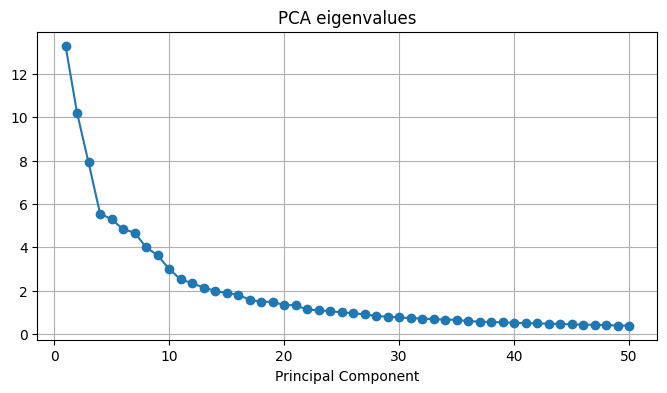

In [22]:
root_folder = "mushrooms"

all_embeds = []
for species in os.listdir(root_folder):
    species_folder = os.path.join(root_folder, species)
    
    embeds = embed_whole_folder(species_folder, bs = 8)
    all_embeds.append(embeds)

all_embeds = np.vstack(all_embeds)

reduced_embeds, pca_model = run_pca(all_embeds, n = 50)
plot_eigenvalues(pca_model)


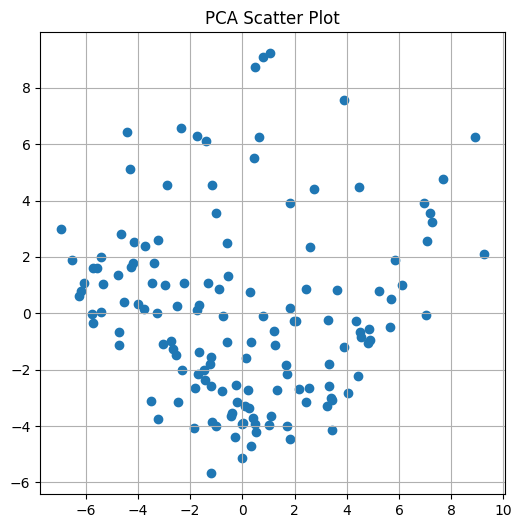

In [24]:
reduced_2d, pca_2d = run_pca(all_embeds, n = 2)
plot_pca_2d(reduced_2d)

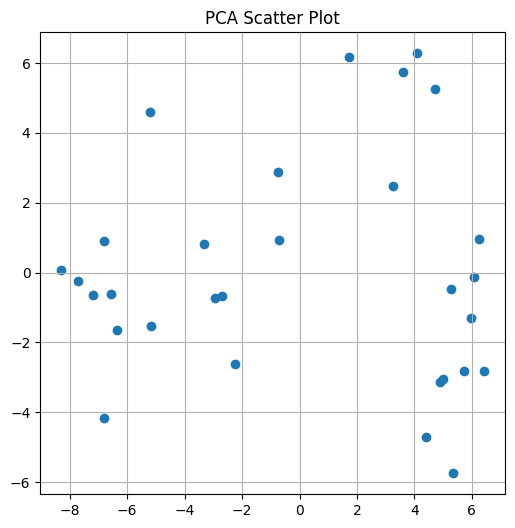

In [27]:
selected_species = ["beechwood_sickener", "beefsteak_fungus"]

embeds_2 = []
for species in selected_species:
    species_folder = os.path.join(root_folder, species)
    embeds = embed_whole_folder(species_folder, bs=8)
    embeds_2.append(embeds)

embeds_2 = np.vstack(embeds_2)

# Run PCA
reduced2, pca2 = run_pca(embeds_2, n=2)
plot_pca_2d(reduced2)

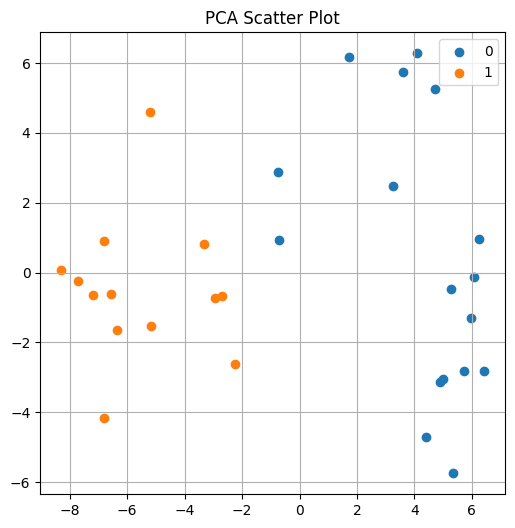

In [28]:
cluster_labels1, kmeans1 = cluster(reduced2)
plot_pca_2d(reduced2, labels = cluster_labels1)